### Inpainting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from nnf import NNF
from time import time

In [73]:
class InpaintNNF:
    """
    Class for inpainting an image using the PatchMatch algorithm.
    Follows downsample-then-upsample approach.
    """
    def __init__(self, image, mask, patch_w=7, max_pm_iters=5):
        """
        image: numpy array of shape (height, width, 3)
        mask: numpy array of shape (height, width)
        """
        # ensure size of image and mask are the same
        assert image.shape[1] == mask.shape[1] and image.shape[0] == mask.shape[0]
        self.image = image
        self.mask = mask
        self.patch_w = patch_w
        self.max_pm_iters = max_pm_iters
        self.pyramid = [] # list to store the downsampled images and masks
        
        self._build_pyramid()
        
    
    def _build_pyramid(self):
        """
        Build the image pyramid.
        """
        self.pyramid.append((self.image, self.mask))
        img = self.image.copy()
        mask = self.mask.copy()
        stopping_patch_size = self.patch_w 
        while img.shape[0] >= stopping_patch_size and img.shape[1] >= stopping_patch_size:
            # img = self._downsample_img(img, 2)
            # mask = self._downsample_mask(mask, 2)
            img, mask = self._downsample_img_and_mask(img, mask, 2)
            self.pyramid.append((img, mask))


    def _downsample_img_and_mask(self, img, mask, factor=2):
        blur_kernel = np.array([[1, 5, 10, 5, 1]]).astype(np.float32)
        # 2d blur kernel
        blur_kernel = blur_kernel.T @ blur_kernel

        # blur the image and mask
        new_img = np.zeros((img.shape[0]//factor, img.shape[1]//factor, 3)).astype(np.float32)
        new_mask = np.ones((mask.shape[0]//factor, mask.shape[1]//factor)).astype(np.float32)

        # pad the image with 2 on all sides
        img = np.pad(img, ((2, 2), (2, 2), (0, 0)), mode='edge').astype(np.float32)
        mask = np.pad(mask, ((2, 2), (2, 2)), mode='edge').astype(np.float32)
        
        # -2 for padding and -1 for avoiding out of bounds for odd sized images
        for x in range(2, img.shape[1]-2-1, 2):
            for y in range(2, img.shape[0]-2-1, 2):
                # channels
                mask_patch = mask[y-2:y+3, x-2:x+3]
                sum_non_zero = np.sum(mask_patch * blur_kernel)
                for c in range(3):
                    img_patch = img[y-2:y+3, x-2:x+3, c]
                    val = np.sum(img_patch * mask_patch * blur_kernel)
                    # divide by num of non zero elements in the mask
                    if sum_non_zero > 0:
                        val /= sum_non_zero
                        new_img[(y-2)//2, (x-2)//2, c] = val
                    else:
                        new_mask[(y-2)//2, (x-2)//2] = 0

        return new_img.astype(np.uint8), new_mask.astype(np.uint8)

        
        
    def _downsample_img(self, img, factor=2):
        return cv2.resize(img, (img.shape[1]//factor, img.shape[0]//factor))
    
    def _upsample_img(self, img, final_size):
        height, width = final_size[:2]
        return cv2.resize(img.astype(np.uint8), (width, height)).astype(np.int32)
    
    def _downsample_mask(self, mask, factor):
        # mask = cv2.resize(mask, (mask.shape[1]//factor, mask.shape[0]//factor))
        # mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)

        # erode the mask with a kernel of size 6x6 and stride 2
        kernel = np.ones((6, 6), np.uint8)
        mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)

        return mask
    
    def _get_patch_similarity(self, nnf_object, ax, ay, bx, by):
        """
        Get the similarity between two patches.
        1 is max similarity, 0 is min similarity.
        """
        patch_dist = nnf_object.patch_distance(ax, ay, bx, by)
        return 1 - patch_dist/nnf_object.MAX_PATCH_DIFF
    
    def weighted_copy(self, src, mask, ax, ay, bx, by, w):
        """
        Copy the patch from src to target with weight w.
        """

        votes = np.zeros((src.shape[0], src.shape[1], 4))

        if mask[ay, ax] == 0:
            return votes
        
        votes[by, bx, 0] += src[ay, ax, 0] * w
        votes[by, bx, 1] += src[ay, ax, 1] * w
        votes[by, bx, 2] += src[ay, ax, 2] * w
        votes[by, bx, 3] += w

        return votes

    def e_step(self, nnf_obj, new_src=None, new_mask=None, upscale=False):
        """
        E-step of the EM algorithm.
        """
        votes = np.zeros((new_src.shape[0], new_src.shape[1], 4))
        for ay in range(nnf_obj.ah):
            for ax in range(nnf_obj.aw):
                
                by, bx = nnf_obj.nnf[ay, ax]
                w = self._get_patch_similarity(nnf_obj, ax, ay, bx, by)

                if upscale:
                    votes += self.weighted_copy(new_src, new_mask, 2*ax, 2*ay, 2*bx, 2*by, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax+1, 2*ay, 2*bx+1, 2*by, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax, 2*ay+1, 2*bx, 2*by+1, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax+1, 2*ay+1, 2*bx+1, 2*by+1, w)

                else:
                    votes += self.weighted_copy(new_src, new_mask, ax, ay, bx, by, w)

        return votes
    
    def m_step(self, new_target, votes):
        """
        M-step of the EM algorithm.
        """
        new_target = new_target.copy()
        for by in range(new_target.shape[0]):
            for bx in range(new_target.shape[1]):
                if votes[by, bx, 3] > 0:
                    new_target[by, bx, 0] = votes[by, bx, 0] / votes[by, bx, 3]
                    new_target[by, bx, 1] = votes[by, bx, 1] / votes[by, bx, 3]
                    new_target[by, bx, 2] = votes[by, bx, 2] / votes[by, bx, 3]
        return new_target


    def expectation_maximization(self, nnf_src_to_target_obj, nnf_target_to_src_obj, level, is_last_iter=False):
        """
        src: numpy array of shape (height, width, 3)
        target: numpy array of shape (height, width, 3)
        """
        # compute the nnfs
        nnf_src_to_target, nnf_src_to_target_dist = nnf_src_to_target_obj.compute_nnf()
        nnf_target_to_src, nnf_target_to_src_dist = nnf_target_to_src_obj.compute_nnf()
        
        upscale = False

        # last iter of the em loop
        if is_last_iter:
            new_src = self.pyramid[level-1][0]
            new_mask = self.pyramid[level-1][1]
            new_target = self._upsample_img(nnf_src_to_target_obj.b.copy(), new_src.shape)
            upscale = True

        else:
            new_src = self.pyramid[level][0]
            new_mask = self.pyramid[level][1]
            new_target = nnf_src_to_target_obj.b.copy()


        # E-step
        votes1 = self.e_step(nnf_src_to_target_obj, new_src, new_mask, upscale=upscale)
        votes2 = self.e_step(nnf_target_to_src_obj, new_src, new_mask, upscale=upscale)
        votes = votes1 + votes2

        # M-step
        new_target = self.m_step(new_target, votes)

        return new_target, nnf_src_to_target, nnf_target_to_src
        
    def inpaint(self):

        inpainted_images = []

        num_pyramid_levels = len(self.pyramid)
        inpainted_img = None
        running_nnf_src_to_target = None
        running_nnf_target_to_src = None
        for level in range(num_pyramid_levels-1, 0, -1):
            start_time = time()

            iterEM = 1+2*level
            iterNNF = min(self.max_pm_iters, 1+level)
            src, mask = self.pyramid[level]
            no_mask = np.ones_like(mask)
            # src_with_mask = src.copy() * np.stack([mask]*3, axis=2)
            
            # print("Level: ", level)
            # print("EM iters: ", iterEM)
            # print("Src size: ", src.shape)
            
            # smallest level
            if level == num_pyramid_levels-1:
                inpainted_img = src.copy()
                
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src, inpainted_img, mask_a=mask, mask_b=no_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src, mask_a=no_mask, mask_b=mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            else:
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src, inpainted_img, mask_a=mask, mask_b=no_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_other_nnf(running_nnf_src_to_target)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src, mask_a=no_mask, mask_b=mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_other_nnf(running_nnf_target_to_src)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            
            # run the EM algorithm multiple times
            for em_step in range(iterEM):
                
                # EM
                inpainted_img, running_nnf_src_to_target, running_nnf_target_to_src = self.expectation_maximization(
                    nnf_src_to_target_obj, nnf_target_to_src_obj, level, is_last_iter=(em_step == iterEM-1))
                
                nnf_src_to_target_obj.b = inpainted_img.copy()
                nnf_target_to_src_obj.a = inpainted_img.copy()     
                # nnf_src_to_target_obj._set_height_width()
                # nnf_target_to_src_obj._set_height_width()
            rgb_inpainted = cv2.cvtColor(inpainted_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
            # plt.imshow(mask)
            plt.imshow(rgb_inpainted)
            plt.show()
            
            # upsample the inpainted image if not the last level
            # if level > 0:
            #     inpainted_img = self._upsample_img(inpainted_img, self.pyramid[level-1][0].shape)

            inpainted_images.append(inpainted_img.astype(np.uint8))

            print("Level", level, "done in", time()-start_time, "seconds.")
            
        return inpainted_images

        

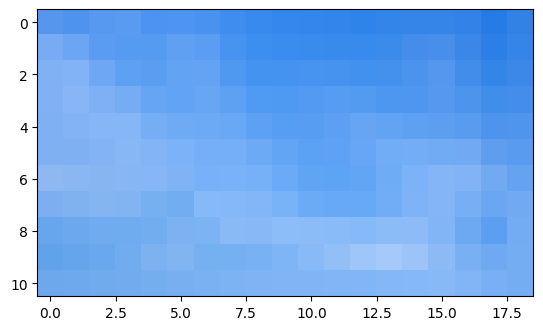

Level 6 done in 0.09358620643615723 seconds.


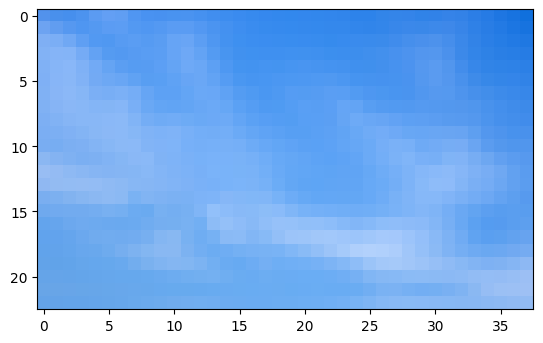

Level 5 done in 0.6209120750427246 seconds.


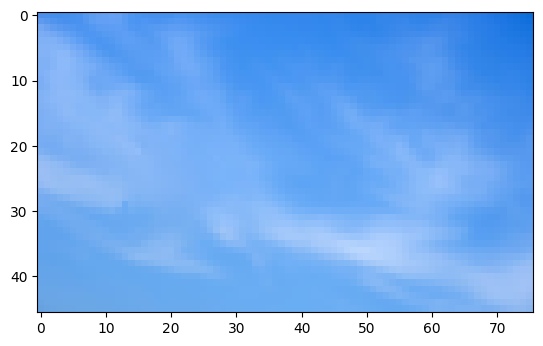

Level 4 done in 4.2360169887542725 seconds.


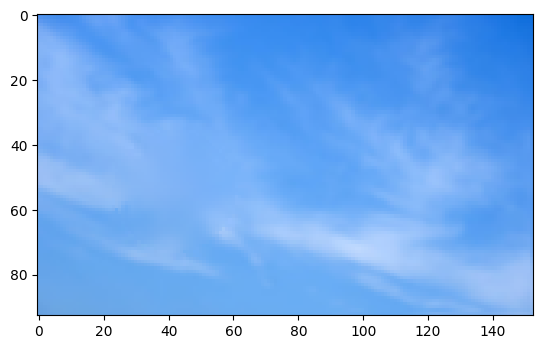

Level 3 done in 15.449196100234985 seconds.


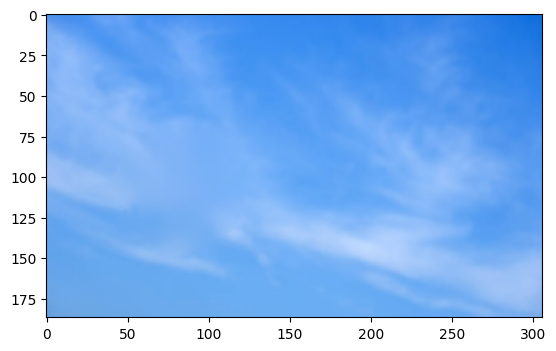

Level 2 done in 57.07998013496399 seconds.


In [ ]:
src_img = cv2.imread("../images/football_sky.jpg")
mask = cv2.imread("../images/football_sky_mask.jpg", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 1, 0).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_img, inpainted_images = inpainter.inpaint()

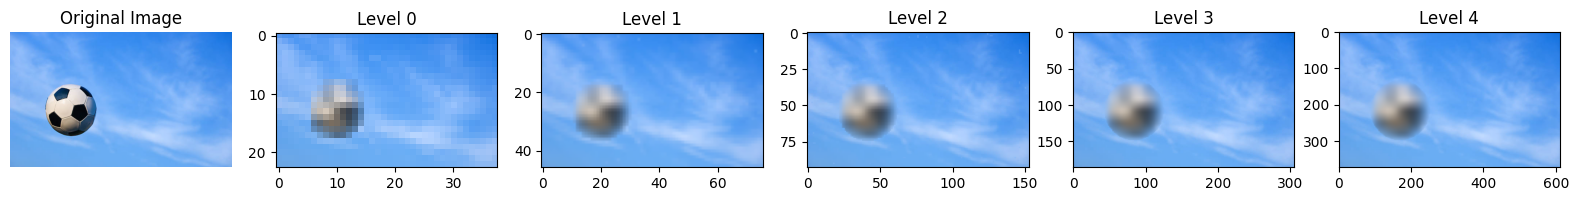

In [ ]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {length-i}")
    # plt.axis("off")
plt.show()

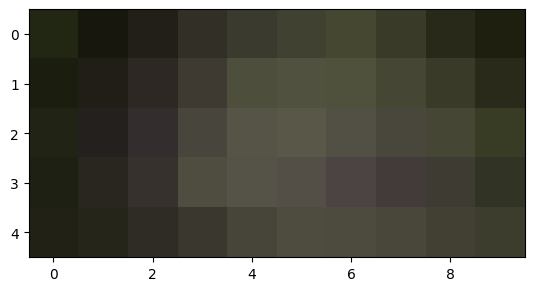

Level 7 done in 0.05194711685180664 seconds.


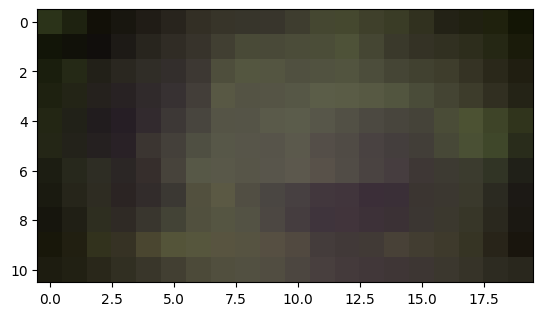

Level 6 done in 0.22148895263671875 seconds.


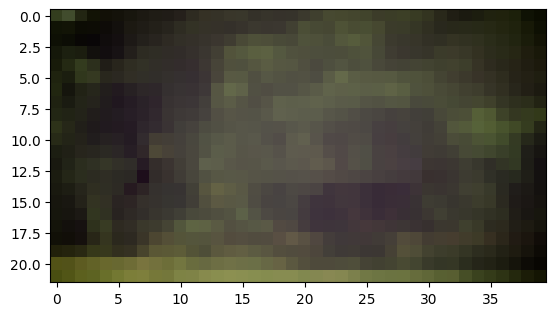

Level 5 done in 1.0855929851531982 seconds.


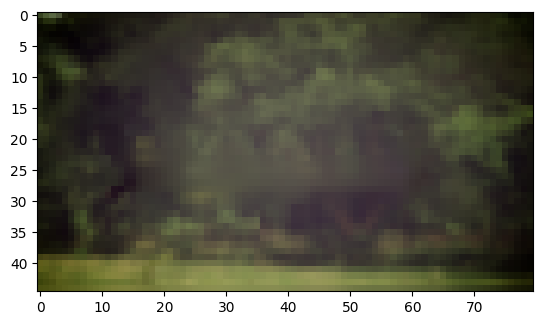

Level 4 done in 4.9171857833862305 seconds.


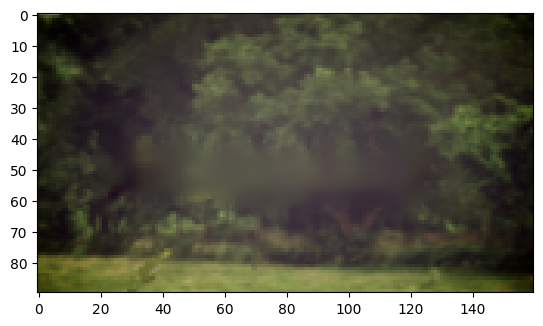

Level 3 done in 16.490120887756348 seconds.


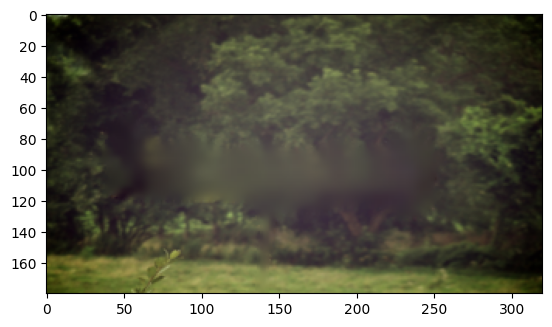

Level 2 done in 57.49699115753174 seconds.


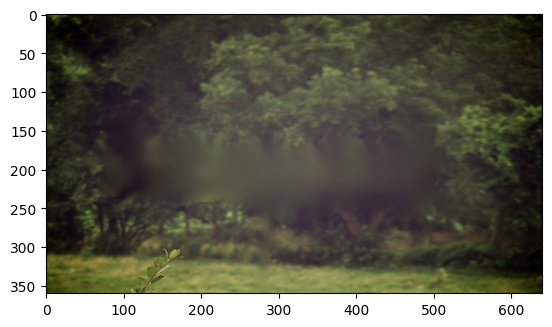

Level 1 done in 367.3042929172516 seconds.


In [74]:
src_img = cv2.imread("../images/forest.png")
mask = cv2.imread("../images/forest_mask.png", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 0, 1).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=5, max_pm_iters=7)
inpainted_images = inpainter.inpaint()

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


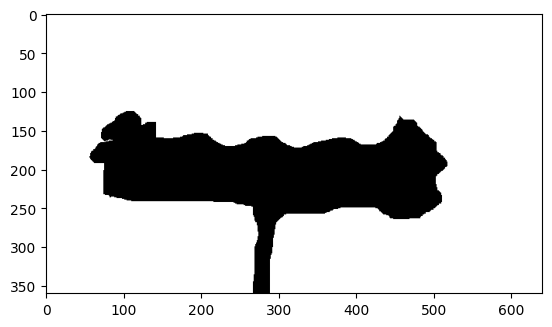

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


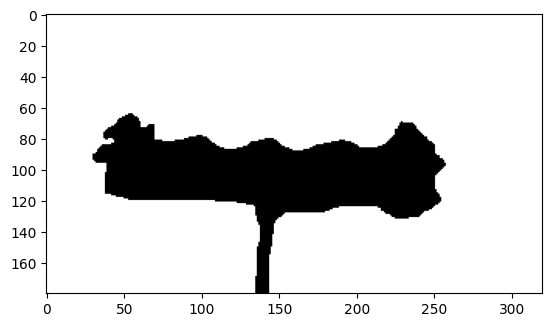

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


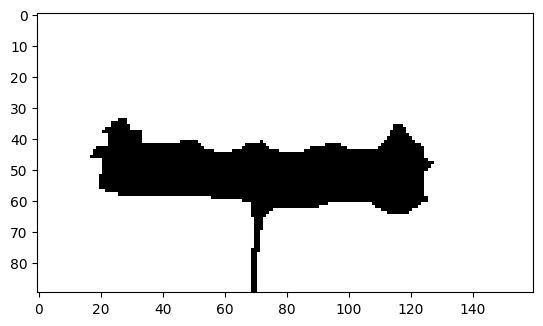

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


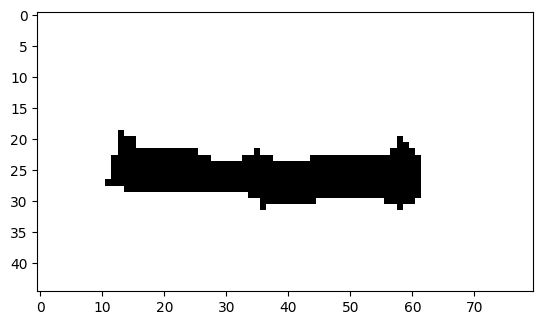

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

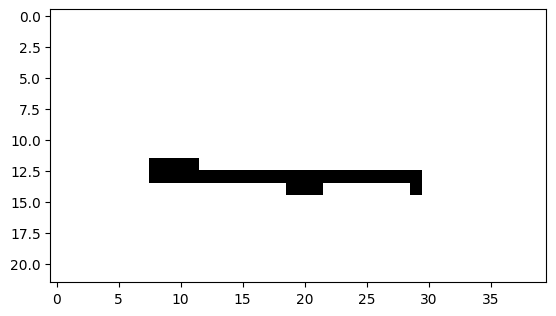

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


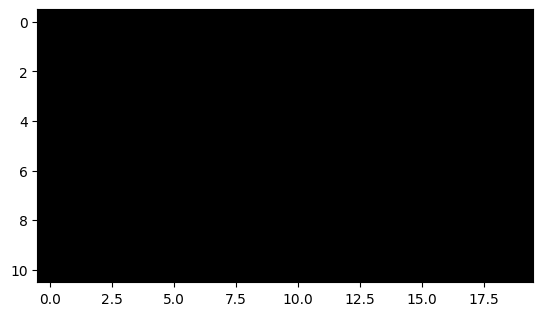

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


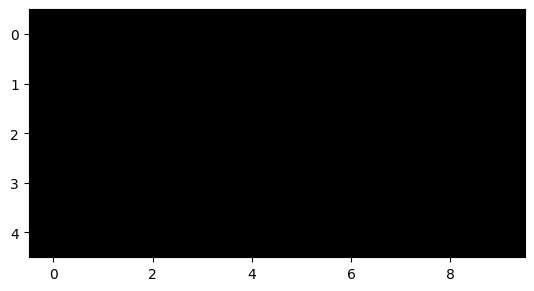

[[1 1 1 1 1]
 [1 1 1 1 1]]


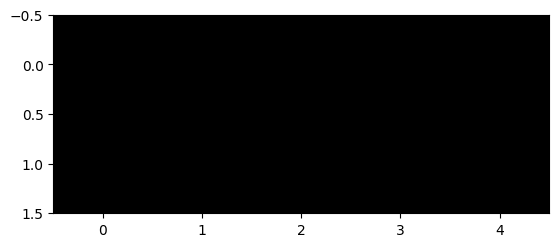

In [71]:
for i in range(len(inpainter.pyramid)):
    plt.imshow(inpainter.pyramid[i][1], cmap='gray')
    print(inpainter.pyramid[i][1])

    plt.show()

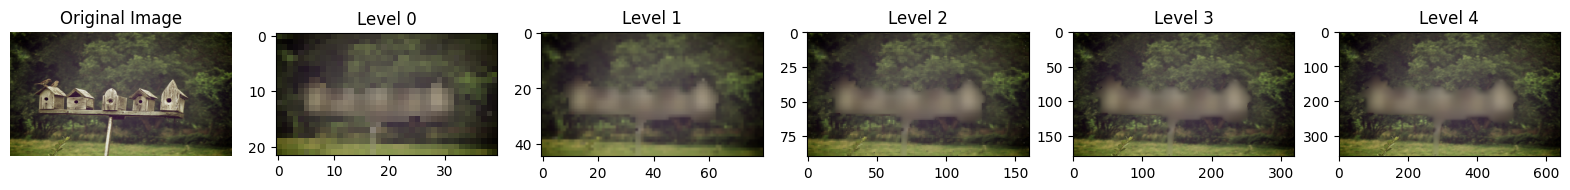

In [4]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    # plt.axis("off")
plt.show()

In [ ]:
src_img = cv2.imread("../images/bridge.jpg")
mask = cv2.imread("../images/bridge_mask.png", cv2.IMREAD_GRAYSCALE)
# mask = np.where(mask > 127, 0, 1).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=15, max_pm_iters=5)
inpainted_images = inpainter.inpaint()

(461, 640)
(461, 640, 3)


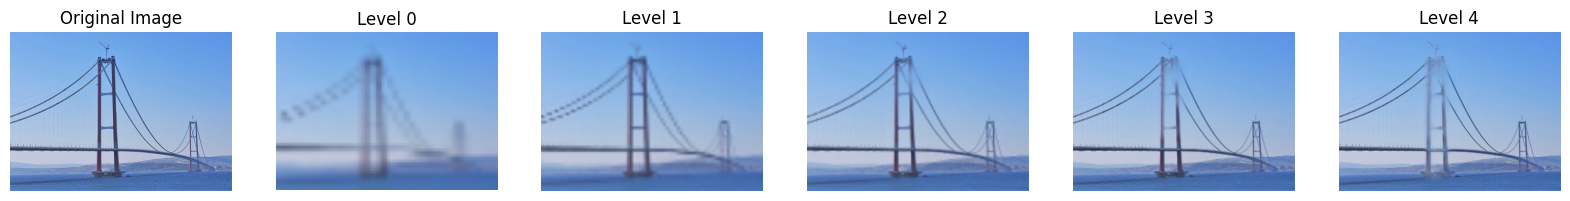

In [ ]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {length-i}")
    plt.axis("off")
plt.show()

In [ ]:
src_img = cv2.imread("../images/green.jpg")
mask = cv2.imread("../images/green_mask.png", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 1, 0).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_images = inpainter.inpaint()

Level:  3
EM iters:  7
Src size:  (12, 12, 3)
Level:  3  done.
Level:  2
EM iters:  5
Src size:  (25, 25, 3)
Level:  2  done.
Level:  1
EM iters:  3
Src size:  (50, 50, 3)
Level:  1  done.


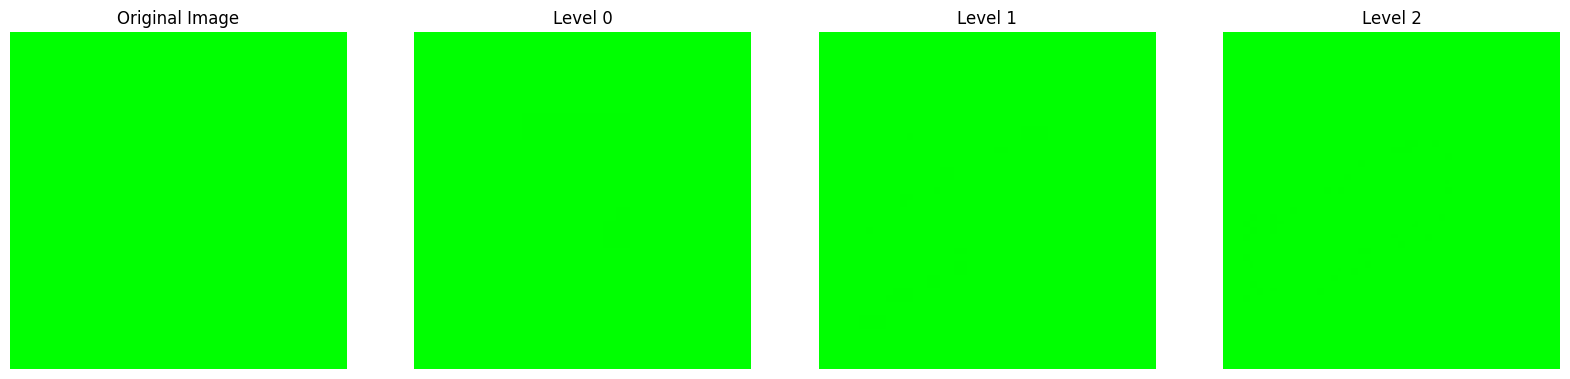

In [4]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    plt.axis("off")
plt.show()